# Preping the Envirnoment 
 
## **Configuration**

### Installing Apache Spark on Colab

The following installs Apache Spark (and its dependencies such as Java JDK 8) for use in Google Colab. Once the Google Colab Session terminates, the following cell must be run again.

In [2]:
import os

# Download Java JDK Version 8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Download and Install Apache Spark (with Findspark)
!wget -q http://www-eu.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

# Change Java Version Frim JDK-11 to JDK-8
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode


**Launch Spark Session on Colab**


In [3]:
# Findspark for Jupyter Notebook (spark-2.4.4-bin-hadoop2.7)
import findspark
findspark.init()

# Start Apache Spark Session & Context
import pyspark
from pyspark.sql import SQLContext
import pyspark.sql.functions as sfunc

## Custom Functions:
def spark_shape(self):
    return (self.count(), len(self.columns))
pyspark.sql.dataframe.DataFrame.shape = spark_shape

def spark_null(self):
  return self.select([sfunc.count(sfunc.when(sfunc.isnan(c) | sfunc.col(c).isNull(), c)).alias(c) for c in self.columns]).show()
pyspark.sql.dataframe.DataFrame.null = spark_null

def accuracy_measure(self, X_test): 
    predictions = self.transform(X_test)
    cm = predictions.select("label", "prediction")
    acc = cm.filter(cm.label == cm.prediction).count() / cm.count()
    return "Model accuracy: %.3f%%" % (acc * 100)

sc = pyspark.SparkContext(appName='titanic-spark')
sqlContext = SQLContext(sc)

print('Master : ', sc.master)
print('Cores  : ', sc.defaultParallelism)

Master :  local[*]
Cores  :  2


In [0]:
# Default Packages (available by Default in Google Colab)
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import random
from pprint import pprint
from matplotlib.lines import Line2D

# Defaults
%matplotlib inline
sns.set() # setting seaborn default for plots


# PySpark Utilities
# import pyspark.sql.functions as F
# from pyspark.sql.types import *
# from pyspark.ml.recommendation import ALS, ALSModel
# from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator
# from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
# from pyspark.mllib.evaluation import RegressionMetrics, RankingMetrics

# Random Seed
SEED = 1492

# Set-up
plt.style.use('seaborn')

## Getting the Data

In [5]:
# Downloading
!wget https://github.com/agconti/kaggle-titanic/raw/master/data/test.csv https://github.com/agconti/kaggle-titanic/raw/master/data/train.csv

--2019-12-22 08:48:35--  https://github.com/agconti/kaggle-titanic/raw/master/data/test.csv
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/agconti/kaggle-titanic/master/data/test.csv [following]
--2019-12-22 08:48:35--  https://raw.githubusercontent.com/agconti/kaggle-titanic/master/data/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28210 (28K) [text/plain]
Saving to: ‘test.csv’

test.csv            100%[===================>]  27.55K  --.-KB/s    in 0.01s   

2019-12-22 08:48:35 (2.20 MB/s) - ‘test.csv’ saved [28210/28210]

--2019-12-22 08:48:35--  https://github.com/agconti/kaggle-titani

In [0]:
# Loading Datasets
train = sqlContext.read.csv(path = 'train.csv', header = True,inferSchema = True)
test = sqlContext.read.csv(path = 'test.csv', header = True,inferSchema = True)

In [7]:
# Data Prepration
# save PassengerId for final submission
passengerId = test.PassengerId
# merge train and test
titanic = train[test.columns].union(test)

# create indexes to separate data later on
train_idx = train.count()
test_idx = test.count()

# Caching to speedup things
train.cache()
test.cache()
titanic.cache()

DataFrame[PassengerId: int, Pclass: int, Name: string, Sex: string, Age: double, SibSp: int, Parch: int, Ticket: string, Fare: double, Cabin: string, Embarked: string]


### Data Definition
**VariableDefinitionKey**

*   *survival* Survival 0 = No, 1 = Yes
*   *pclass* Ticket class 1 = 1st, 2 = 2nd, 3 = 3rd
*   *sex* Sex
*   *Age* Age in years
*   *sibsp* # of siblings / spouses aboard the Titanic
*   *parch* # of parents / children aboard the Titanic
*   *ticket* Ticket number
*   *fare* Passenger fare
*   *cabin* Cabin number
*   *embarked* Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton

**Variable Notes**

*   *pclass*: A proxy for socio-economic status (SES)
  *      1st = Upper
  *      2nd = Middle
  *      3rd = Lower

*   *age*: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

*   sibsp: The dataset defines family relations in this way...
  *       Sibling = brother, sister, stepbrother, stepsister
  *       Spouse = husband, wife (mistresses and fiancés were ignored)

*   parch: The dataset defines family relations in this way...
  *       Parent = mother, father
  *       Child = daughter, son, stepdaughter, stepson
  *       Some children travelled only with a nanny, therefore parch=0 for them.



In [8]:
# Let's take a look
# describe(include = ['O']) will show the descriptive statistics of object data types
# Replaced with dtype string
objs = []
for (i, j) in titanic.dtypes:
  if j == 'string':
    objs.append(i)

titanic[objs].describe().show()

+-------+--------------------+------+------------------+-----+--------+
|summary|                Name|   Sex|            Ticket|Cabin|Embarked|
+-------+--------------------+------+------------------+-----+--------+
|  count|                1309|  1309|              1309|  295|    1307|
|   mean|                null|  null| 249039.1368861024| null|    null|
| stddev|                null|  null|442685.31767656433| null|    null|
|    min|"Andersson, Mr. A...|female|            110152|  A10|       C|
|    max|van Melkebeke, Mr...|  male|         WE/P 5735|    T|       S|
+-------+--------------------+------+------------------+-----+--------+




This shows that there are duplicate Ticket number and Cabins shared. 

The highest number of duplicate ticket number is "CA. 2343", It has been repeated 7 times. 

Similarly, the highest number of people using the same cabin is 4. 
They are using cabin number "C23 C25 C27".

We also see that 644 people were embarked from port "S".

Among 891 rows, 577 were Male and the rest were Female.


**We use info() method to see more information of our train dataset.**


In [9]:
titanic.show(5)
for i in titanic.schema:
  display(i)
display( 'NaN Values')
titanic.select([sfunc.count(sfunc.when(sfunc.isnan(c), c)).alias(c) for c in titanic.columns]).show()
display('NaN & NULL Values')
titanic.select([sfunc.count(sfunc.when(sfunc.isnan(c) | sfunc.col(c).isNull(), c)).alias(c) for c in titanic.columns]).show()
titanic.describe().show()

+-----------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
+-----------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
only showing top 5 rows



StructField(PassengerId,IntegerType,true)

StructField(Pclass,IntegerType,true)

StructField(Name,StringType,true)

StructField(Sex,StringType,true)

StructField(Age,DoubleType,true)

StructField(SibSp,IntegerType,true)

StructField(Parch,IntegerType,true)

StructField(Ticket,StringType,true)

StructField(Fare,DoubleType,true)

StructField(Cabin,StringType,true)

StructField(Embarked,StringType,true)

'NaN Values'

+-----------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|     0|   0|  0|  0|    0|    0|     0|   0|    0|       0|
+-----------+------+----+---+---+-----+-----+------+----+-----+--------+



'NaN & NULL Values'

+-----------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|     0|   0|  0|263|    0|    0|     0|   1| 1014|       2|
+-----------+------+----+---+---+-----+-----+------+----+-----+--------+

+-------+-----------------+------------------+--------------------+------+------------------+------------------+------------------+------------------+------------------+-----+--------+
|summary|      PassengerId|            Pclass|                Name|   Sex|               Age|             SibSp|             Parch|            Ticket|              Fare|Cabin|Embarked|
+-------+-----------------+------------------+--------------------+------+------------------+------------------+------------------+------------------+------------------+-----+--------+
|  count|             1309|              1309|                1309|  1309|     

Age, Cabin values are missing ( only present in 714, 204 respectively )

There is also 2 rows with missing Embarked Info


### Next we Look into Features and Survival

We will analyze the relationship between different features and Survival. We see how different features are correlated with the different survival propability.

We will plot different diagrams to visualize the findings.


In [10]:
# Survival and Precent Working on train set
survived = train[train['Survived'] == 1]
not_survived = train[train['Survived'] == 0]             # Using train dataset since titanic includes test as well

print ("Survived: %i (%.1f%%)"%(survived.count(), float(survived.count())/train.count()*100.0))
print ("Not Survived: %i (%.1f%%)"%(not_survived.count(), float(not_survived.count())/train.count()*100.0))
print ("Total: %i"%train.count())

Survived: 342 (38.4%)
Not Survived: 549 (61.6%)
Total: 891


In [11]:
type(survived)

pyspark.sql.dataframe.DataFrame

## Pclass vs. Survival

assumption: Higher Classes have better chance of survival


+------+--------+-----+
|Pclass|Survived|count|
+------+--------+-----+
|     1|       0|   80|
|     3|       1|  119|
|     1|       1|  136|
|     2|       1|   87|
|     2|       0|   97|
|     3|       0|  372|
+------+--------+-----+

+------+-------------------+
|Pclass|           Survival|
+------+-------------------+
|     1| 0.6296296296296297|
|     3|0.24236252545824846|
|     2|0.47282608695652173|
+------+-------------------+



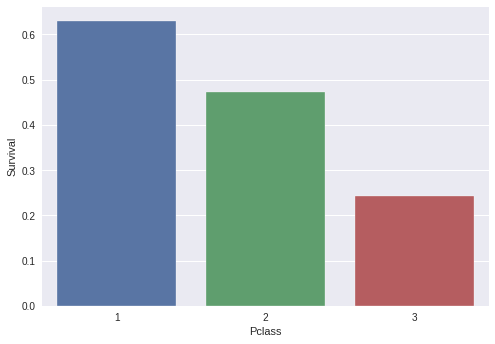

In [12]:
train[['Pclass', 'Survived']].groupby('Pclass', 'Survived').count().show()

# train[['Pclass', 'Survived']].groupby('Pclass').mean().withColumnRenamed('avg(Survived)', 'Survival')[['Pclass', 'Survival']].show()
train[['Pclass', 'Survived']].groupby('Pclass').mean('Survived').withColumnRenamed('avg(Survived)', 'Survival').show()

# graph train Pclass VS Survived
data = train[['Pclass', 'Survived']].groupby('Pclass').mean().withColumnRenamed('avg(Survived)', 'Survival').toPandas()
sns.barplot(x='Pclass', y='Survival', data=data)

## Sex vs. Survival

assumption: Females have better chance of survival


+------+-----+
|   Sex|count|
+------+-----+
|female|  466|
|  male|  843|
+------+-----+



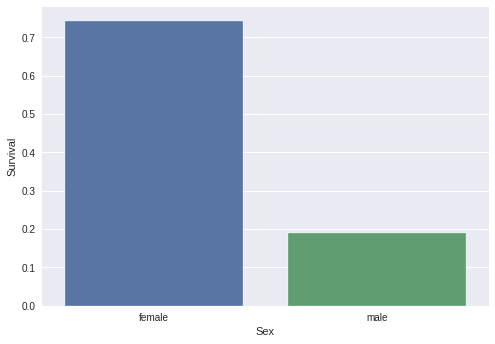

In [13]:
titanic.groupBy('Sex').count().show()

# Graph it
data = train[['Sex', 'Survived']].groupby('Sex').mean().withColumnRenamed('avg(Survived)', 'Survival').toPandas()
sns.barplot(x='Sex', y='Survival', data=data)

## Pclass & Sex vs. Survival

Above, we just find out how many males and females are there in each Pclass.

We then plot a stacked bar diagram with that information. We found that there are more males among the 3rd Pclass passengers.


+------+------+----+
|Pclass|female|male|
+------+------+----+
|     2|   106| 171|
|     1|   144| 179|
|     3|   216| 493|
+------+------+----+



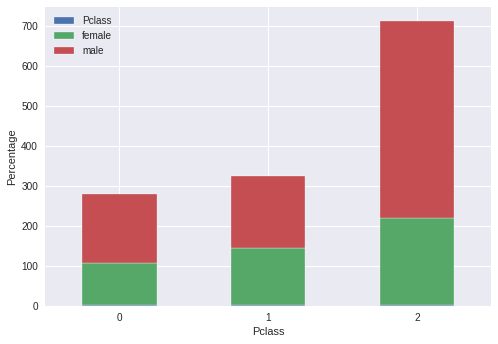

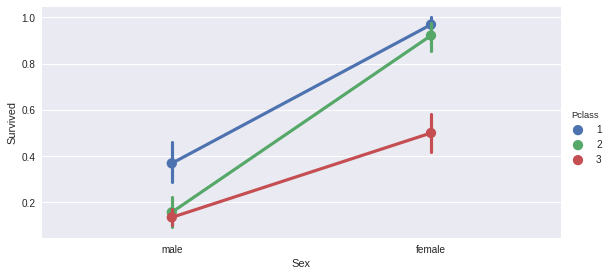

In [14]:
tab = titanic.stat.crosstab("Pclass", "Sex").withColumnRenamed('Pclass_Sex','Pclass')
tab.show()

# Floating division of dataframe and other, element-wise (binary operator truediv).
# Equivalent to dataframe / other, but with support to substitute a fill_value for missing data in one of the inputs. With reverse version, rtruediv.
tab = tab.toPandas()

tab.astype(float).plot(kind="bar", stacked=True )
# tab.div(tab.astype(float), axis=0).plot(kind="bar", stacked=True)

# The graph is showing total without differentiation between males & females

plt.xlabel('Pclass')
plt.ylabel('Percentage')
plt.xticks(rotation=0)

train_df = train.toPandas()

sns.catplot('Sex', 'Survived', hue='Pclass', height=4, aspect=2, data=train_df, kind='point')


From the above plot, it can be seen that:

*    Women from 1st and 2nd Pclass have almost 100% survival chance.
*    Men from 2nd and 3rd Pclass have only around 10% survival chance.

Generally, Women have a higher chance of survival

## Pclass, Sex & Embarked vs. Survival


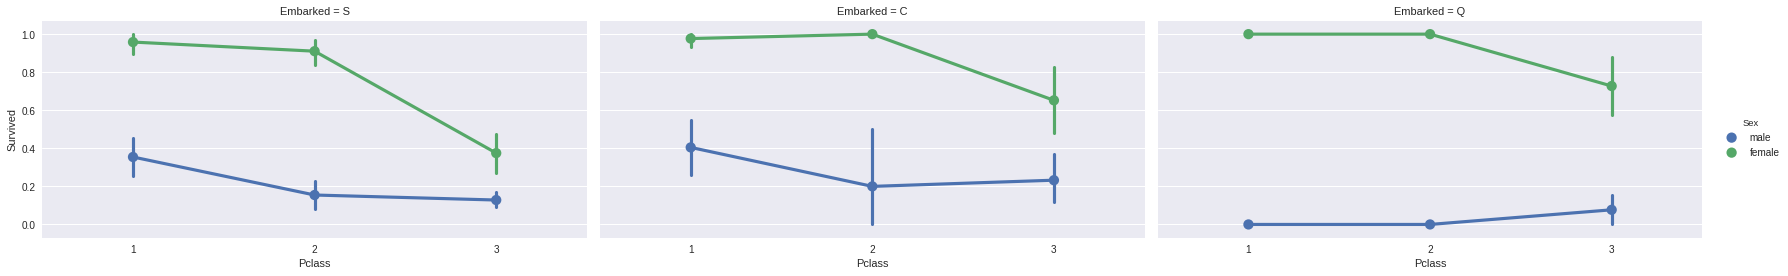

In [15]:
sns.catplot('Pclass', 'Survived', hue='Sex', col='Embarked', height=4, aspect=2, data=train_df, kind='point')


From the above plot, it can be seen that:

*    Almost all females from Pclass 1 and 2 survived.
*    Females dying were mostly from 3rd Pclass.
*    Males from Pclass 1 only have slightly higher survival chance than Pclass 2 and 3.

Embarked shows interesting graph

## Embarked vs. Survived


+--------+-----+
|Embarked|count|
+--------+-----+
|       Q|   77|
|    null|    2|
|       C|  168|
|       S|  644|
+--------+-----+

+--------+--------+-----+
|Embarked|Survived|count|
+--------+--------+-----+
|    null|       1|    2|
|       Q|       1|   30|
|       S|       0|  427|
|       S|       1|  217|
|       C|       1|   93|
|       Q|       0|   47|
|       C|       0|   75|
+--------+--------+-----+

+--------+-------------------+
|Embarked|      avg(Survived)|
+--------+-------------------+
|       Q|0.38961038961038963|
|    null|                1.0|
|       C| 0.5535714285714286|
|       S|0.33695652173913043|
+--------+-------------------+



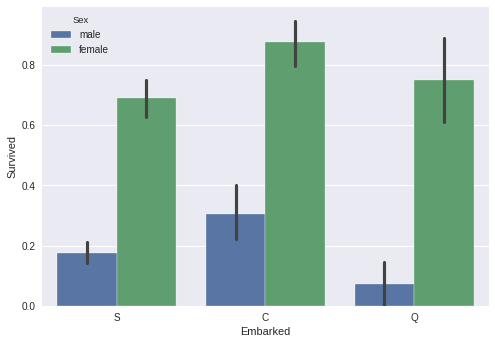

In [16]:
train.groupBy('Embarked').count().show()
train.groupby('Embarked', 'Survived').count().show()
train[['Embarked', 'Survived']].groupby(['Embarked']).mean().show()

sns.barplot('Embarked', 'Survived', hue='Sex', data = train_df)

## Parch vs. Survival

+-----+-----+
|Parch|count|
+-----+-----+
|    1|  118|
|    6|    1|
|    3|    5|
|    5|    5|
|    4|    4|
|    2|   80|
|    0|  678|
+-----+-----+

+-----+--------+-----+
|Parch|Survived|count|
+-----+--------+-----+
|    0|       1|  233|
|    0|       0|  445|
|    1|       0|   53|
|    1|       1|   65|
|    2|       1|   40|
|    2|       0|   40|
|    3|       1|    3|
|    3|       0|    2|
|    4|       0|    4|
|    5|       0|    4|
|    5|       1|    1|
|    6|       0|    1|
+-----+--------+-----+

+-----+-------------------+
|Parch|      Survival Rate|
+-----+-------------------+
|    0|0.34365781710914456|
|    1| 0.5508474576271186|
|    2|                0.5|
|    3|                0.6|
|    4|                0.0|
|    5|                0.2|
|    6|                0.0|
+-----+-------------------+



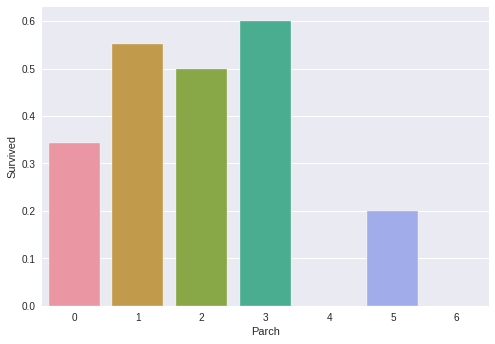

In [17]:
train.groupby('Parch').count().show()
train.groupby('Parch', 'Survived').count().sort('Parch').show()
train[['Parch', 'Survived']].groupby(['Parch']).mean().sort('Parch').withColumnRenamed('avg(Survived)', 'Survival Rate')['Parch', 'Survival Rate'].show()

sns.barplot(x='Parch', y='Survived', ci=None, data=train.toPandas()) # ci=None will hide the error bar

## SibSp vs. Survival

+-----+-----+
|SibSp|count|
+-----+-----+
|    1|  209|
|    3|   16|
|    5|    5|
|    4|   18|
|    8|    7|
|    2|   28|
|    0|  608|
+-----+-----+

+-----+--------+-----+
|SibSp|Survived|count|
+-----+--------+-----+
|    1|       0|   97|
|    3|       1|    4|
|    4|       0|   15|
|    1|       1|  112|
|    0|       0|  398|
|    2|       1|   13|
|    0|       1|  210|
|    2|       0|   15|
|    5|       0|    5|
|    8|       0|    7|
|    3|       0|   12|
|    4|       1|    3|
+-----+--------+-----+

+-----+----------+-------------------+
|SibSp|avg(SibSp)|      avg(Survived)|
+-----+----------+-------------------+
|    1|       1.0| 0.5358851674641149|
|    3|       3.0|               0.25|
|    5|       5.0|                0.0|
|    4|       4.0|0.16666666666666666|
|    8|       8.0|                0.0|
|    2|       2.0| 0.4642857142857143|
|    0|       0.0|0.34539473684210525|
+-----+----------+-------------------+



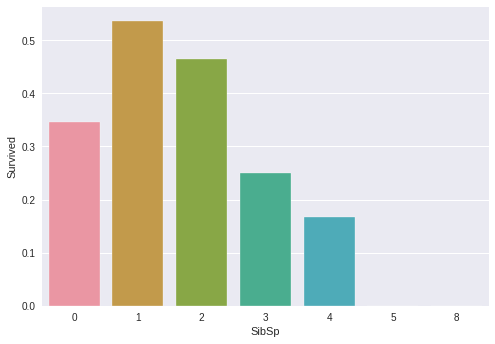

In [18]:
train.groupby('SibSp').count().show()
train.groupby('SibSp', 'Survived').count().show()
train[['SibSp', 'Survived']].groupby(['SibSp']).mean().show()

# Graph
sns.barplot( x = 'SibSp', y = 'Survived', ci = None, data = train.toPandas())

## Age vs Survival

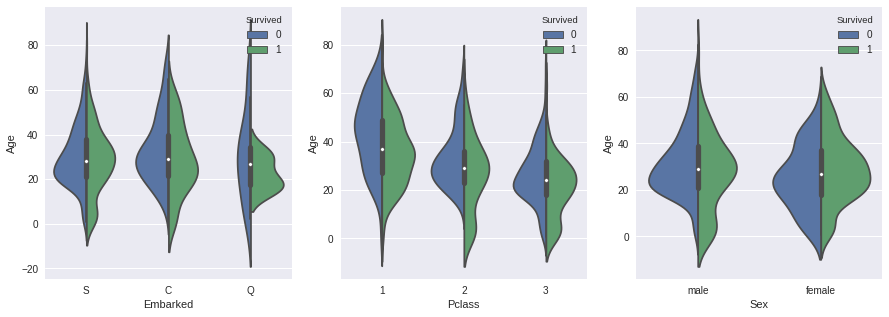

In [19]:
fig , (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(15,5)

sns.violinplot(x="Embarked", y="Age", hue="Survived", data=train.toPandas(), split=True, ax=ax1)
sns.violinplot(x="Pclass", y="Age", hue="Survived", data=train.toPandas(), split=True, ax=ax2)
sns.violinplot(x="Sex", y="Age", hue="Survived", data=train.toPandas(), split=True, ax=ax3)


From Pclass Violinplot, we can see

*    1st Class has very few childern population
*    1st Class has more old population
*    Almost all childern are in 2nd class survived
*    majority of 3rd class childern survived
*    Younger pop survived in Class 1 vs Older pop

From Sex violinplot, we see

*    Most male children (between age 0 to 14) survived.
*    Females with age between 18 to 40 have better survival chance.
*    Older Males has a lower chance of survival than females


## Correlating Features

Heatmap of Correlation between different features:

    Positive numbers = Positive correlation, i.e. increase in one feature will increase the other feature & vice-versa. 
    Negative numbers = Negative correlation, i.e. increase in one feature will decrease the other feature & vice-versa.

In our case, we focus on which features have strong positive or negative correlation with the Survived feature

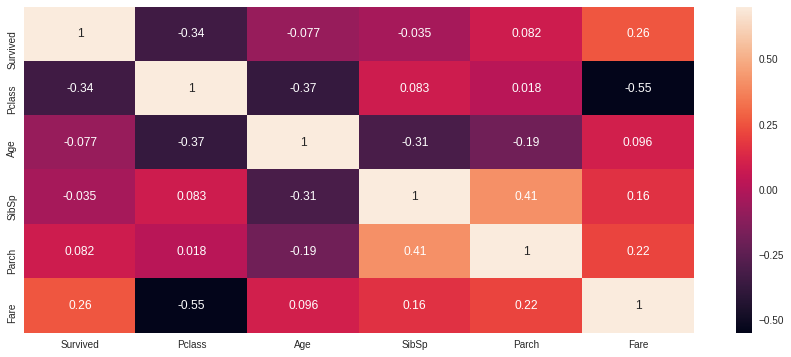

In [20]:
plt.figure(figsize=(15,6))
sns.heatmap(train.toPandas().drop('PassengerId',axis=1).corr(), vmax=0.7, square=False, annot=True)

# Feature Engineering 
## Feature Extraction

In this section, we select the appropriate features to train our classifier. Here, we create new features based on existing features. We also convert categorical features into numeric form.

### Title Feature

Let's first extract titles from Name column

In [21]:
# Extracting Title 
# create a new feature to extract title names from the Name column

getTitle = sfunc.udf(lambda name: name.split(',')[1].split('.')[0].strip(), sfunc.StringType())
titanic = titanic.withColumn('Title', getTitle(titanic['Name']))

# normalize the titles
normalized_titles = {
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Royalty",
    "Don":        "Royalty",
    "Sir" :       "Royalty",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "the Countess":"Royalty",
    "Dona":       "Royalty",
    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Master",
    "Lady" :      "Royalty"
}

# map the normalized titles to the current titles 
# mapTitle = sfunc.udf( lambda title: normalized_titles[title] )
# titanic = titanic.withColumn('Title', mapTitle(titanic['Title']))
titanic = titanic.replace( normalized_titles, subset='Title' )

## view value counts for the normalized titles
titanic.stat.crosstab("Title", "Sex").show()

+---------+------+----+
|Title_Sex|female|male|
+---------+------+----+
|   Master|     0|  61|
|       Mr|     0| 757|
|      Mrs|   200|   0|
|  Officer|     1|  22|
|     Miss|   262|   0|
|  Royalty|     3|   3|
+---------+------+----+



In [22]:
## Indexing Title
from pyspark.ml.feature import StringIndexer
si = StringIndexer(inputCol = 'Title', outputCol = 'Title_indexed')
titanic = si.fit(titanic).transform(titanic).drop('Title').withColumnRenamed('Title_indexed','Title')
titanic.show(5)

+-----------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+-----+
|PassengerId|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|Title|
+-----------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+-----+
|          1|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|  0.0|
|          2|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|  2.0|
|          3|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|  1.0|
|          4|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|  2.0|
|          5|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|  0.0|
+-----------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------

In [0]:
### Using UDF (less efficient - prevents spark optimizations )
# titanic.select('Name', sfunc.split(pattern='.')[1].sfunc.split('.')[0].sfunc.strip(), sfunc.StringType())
# titanic.select(sfunc.split(titanic.Name, ",") ).show()#.sfunc.split(',').show()#.sfunc.strip(), sfunc.StringType())
# titanic.show(10)

### Another way to do UDF
# def square(x):
#     return x**2

## As long as the python function’s output has a corresponding data type in Spark, then I can turn it into a UDF. 
## When registering UDFs, I have to specify the data type using the types from pyspark.sql.types. All the types supported by PySpark can be found here.

## Here’s a small gotcha — because Spark UDF doesn’t convert integers to floats, unlike Python function which works for both integers and floats, a Spark UDF will return a column of NULLs if the input data type doesn’t match the output data type, as in the following example.

## Registering UDF with <integer> type output <Integer> type output
# from pyspark.sql.types import IntegerType
# square_udf_int = udf(lambda z: square(z), IntegerType())

## Cabin Feature

From the previous cell it appears as if most of the cabins consist of a single letter at the beginning followed by a 2 or three digit number. It seems logical that the letter would represent the deck or section of boat where the cabin was located followed by the room number. It would seem that if you knew the section of the boat where someone was staying it would give you a lot of insight into their chances of survival. With that in mind let's work on cleaning up that column and seeing what we can get out of it.


In [24]:
titanic.describe().show()
titanic.select(titanic['Cabin']).show(3)
titanic.show(5)

+-------+-----------------+------------------+--------------------+------+------------------+------------------+------------------+------------------+------------------+-----+--------+------------------+
|summary|      PassengerId|            Pclass|                Name|   Sex|               Age|             SibSp|             Parch|            Ticket|              Fare|Cabin|Embarked|             Title|
+-------+-----------------+------------------+--------------------+------+------------------+------------------+------------------+------------------+------------------+-----+--------+------------------+
|  count|             1309|              1309|                1309|  1309|              1046|              1309|              1309|              1309|              1308|  295|    1307|              1309|
|   mean|            655.0| 2.294881588999236|                null|  null|29.881137667304014|0.4988540870893812|0.3850267379679144| 249039.1368861024| 33.29547928134553| null|    null|

### Deduce Deck and Room information
**Deducing Deck & Room numbers from Cabin**

We will leverage the Cabin feature and simply extract the first letter of the cabin which determines the section where the room would have been. This is potentially relevant since it is possible that some cabins were closer to the life boats and thus those that were closer to them may have had a greater chance at securing a spot.


In [0]:
### Filling missing data

#     Now we will fill the missing data
# Fill Cabin NaN with U for unknown
titanic = titanic.na.fill({'Cabin': 'U'})

# map first letter of cabin to itself
# mapDeck = sfunc.udf( lambda x: x[0] )
# titanic = titanic.withColumn('Deck', mapDeck(titanic['Cabin']) )
titanic = titanic.withColumn('Deck', titanic.Cabin.substr(1,1) )

# Create room number
# titanic['Room'] = titanic['Cabin'].str.slice(1,5).str.extract("([0-9]+)", expand=False).astype("float")
# mapRoom = sfunc.udf( lambda x: x[1:4].extract("(0-9)+", expand=False).astype('float'))
# titanic = titanic.withColumn('Room', mapRoom(titanic['Cabin']) )
titanic = titanic.withColumn('Room', titanic.Cabin.substr(2,5).astype("float") )

# Fill Room Column with Room mean()
room_mean = titanic.groupBy().mean('Room').first()[0]
titanic = titanic.withColumn('Room', titanic.Cabin.substr(2,5).astype("float") ).na.fill(room_mean)


In [26]:
# After Filling ['Cabin', 'Deck', 'Room']
# Now we Index Them.

for i in ['Cabin', 'Deck']:
  si = StringIndexer(inputCol = f'{i}', outputCol = f'{i}_indexed')
  titanic = si.fit(titanic).transform(titanic).drop(f'{i}').withColumnRenamed(f'{i}_indexed',f'{i}')

titanic.show(4)

+-----------+------+--------------------+------+----+-----+-----+----------------+-------+--------+-----+---------+-----+----+
|PassengerId|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Embarked|Title|     Room|Cabin|Deck|
+-----------+------+--------------------+------+----+-----+-----+----------------+-------+--------+-----+---------+-----+----+
|          1|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25|       S|  0.0|49.379032|  0.0| 0.0|
|          2|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|       C|  2.0|     85.0| 45.0| 1.0|
|          3|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925|       S|  1.0|49.379032|  0.0| 0.0|
|          4|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1|       S|  2.0|    123.0| 74.0| 1.0|
+-----------+------+--------------------+------+----+-----+-----+----------------+-------+--------+-----+------

In [0]:
# numVars = ['Survived','Age','SibSp','Parch','Fare']
# def countNull(df,var):
# return df.where(df[var].isNull()).count()
 
# missing = {var: countNull(df,var) for var in numVars}
# age_mean = df.groupBy().mean('Age').first()[0]
# fare_mean = df.groupBy().mean('Fare').first()[0]
# df = df.na.fill({'Age':age_mean,'Fare':fare_mean})
# titanic = titanic.drop('Room')
# titanic.show(3)

In [28]:
# Check Nulls & NaN
titanic.null()
titanic.printSchema()

+-----------+------+----+---+---+-----+-----+------+----+--------+-----+----+-----+----+
|PassengerId|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Embarked|Title|Room|Cabin|Deck|
+-----------+------+----+---+---+-----+-----+------+----+--------+-----+----+-----+----+
|          0|     0|   0|  0|  0|    0|    0|     0|   0|       2|    0|   0|    0|   0|
+-----------+------+----+---+---+-----+-----+------+----+--------+-----+----+-----+----+

root
 |-- PassengerId: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = false)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = false)
 |-- Embarked: string (nullable = true)
 |-- Title: double (nullable = false)
 |-- Room: float (nullable = false)
 |-- Cabin: double (nullable = false)
 |-- Deck: double (nullable = false)



## Emabrked Feature

We now convert the categorical value of Embarked into numeric. We represent 0 as S, 1 as C and 2 as Q.

There are empty values for some rows for Embarked column. The empty values are represented as "nan" in below list.


In [29]:
titanic.select('Embarked').distinct().show()

## Filling the Null values with the max occurance
emabrked_agg = titanic.groupBy('Embarked').count()
emabrked_agg.show()


+--------+
|Embarked|
+--------+
|       Q|
|    null|
|       C|
|       S|
+--------+

+--------+-----+
|Embarked|count|
+--------+-----+
|       Q|  123|
|    null|    2|
|       C|  270|
|       S|  914|
+--------+-----+




We find that category "S" has maximum passengers. Hence, we replace "nan" values with "S". ***Could be refined in the future***


In [30]:
## Filling Null Embarked with Max port counted
max_port_count = titanic.groupBy('Embarked').count().agg({"count": "max"}).collect()[0][0]
max_port = emabrked_agg.filter(f'count == {max_port_count}' ).collect()[0][0]

titanic = titanic.na.fill({'Embarked': f'{max_port}'})
titanic.select('Embarked').distinct().show()

+--------+
|Embarked|
+--------+
|       Q|
|       C|
|       S|
+--------+



We now convert the categorical value of Embarked into numeric vectors.

In [31]:
target = 'Embarked'
si = StringIndexer(inputCol = f'{target}', outputCol = f'{target}_indexed')
titanic = si.fit(titanic).transform(titanic).drop(f'{target}').withColumnRenamed(f'{target}_indexed',f'{target}')
titanic.select('Embarked').distinct().show()

+--------+
|Embarked|
+--------+
|     0.0|
|     1.0|
|     2.0|
+--------+



## Sex Feature

We convert the categorical value of Sex into numeric. We represent 0 as female and 1 as male.


In [32]:
# Indexing Sex 
titanic.select('Sex').distinct().show()

target = 'Sex'
si = StringIndexer(inputCol = f'{target}', outputCol = f'{target}_indexed')
titanic = si.fit(titanic).transform(titanic).drop(f'{target}').withColumnRenamed(f'{target}_indexed',f'{target}')

titanic.select('Sex').distinct().show()

+------+
|   Sex|
+------+
|female|
|  male|
+------+

+---+
|Sex|
+---+
|0.0|
|1.0|
+---+



## Age Feature

We first fill the NULL values of Age with a random number between (mean_age - std_age) and (mean_age + std_age).

We then create a new column named AgeBand. This categorizes age into 5 different age range. I could use it to estimate the missing ages just a little bit better. The next step is to estimate the missing Age values

**After experminating with turn this feature into catgeories it proved that its better off as is**


In [33]:
# Checking NaNs
titanic.select([sfunc.count(sfunc.when(sfunc.isnan(c) | sfunc.col(c).isNull(), c)).alias(c) for c in titanic.columns]).show() 
display( titanic.count())

+-----------+------+----+---+-----+-----+------+----+-----+----+-----+----+--------+---+
|PassengerId|Pclass|Name|Age|SibSp|Parch|Ticket|Fare|Title|Room|Cabin|Deck|Embarked|Sex|
+-----------+------+----+---+-----+-----+------+----+-----+----+-----+----+--------+---+
|          0|     0|   0|  0|    0|    0|     0|   0|    0|   0|    0|   0|       0|  0|
+-----------+------+----+---+-----+-----+------+----+-----+----+-----+----+--------+---+



1309

In [34]:
## Another Approach
'''
Instead of simply filling in the missing Age values with the mean or median age of the dataset, by grouping the data 
by a passenger’s sex, class, and title, we can drill down a bit deeper and get a closer approximation of what a passenger’s age might have been.

Using the grouped.Age variable, we can fill in the missing values for Age.
'''

# group by Sex, Pclass, and Title 
age_agg = titanic.groupby(['Sex','Pclass', 'Title'])  
# view the median Age by the grouped features 
age_agg.agg({'Age':'mean'}).show()

+---+------+-----+------------------+
|Sex|Pclass|Title|          avg(Age)|
+---+------+-----+------------------+
|0.0|     2|  0.0|33.822849462365596|
|0.0|     3|  3.0|13.785827956989248|
|0.0|     2|  3.0|2.7572727272727273|
|1.0|     1|  4.0|              49.0|
|1.0|     3|  1.0| 27.39323010752689|
|0.0|     2|  4.0|              40.7|
|1.0|     1|  1.0| 30.44159729448491|
|0.0|     1|  4.0| 50.94825268817204|
|1.0|     3|  2.0| 36.71884164222874|
|0.0|     1|  3.0|             6.984|
|1.0|     1|  5.0|              40.0|
|1.0|     1|  2.0| 43.75372208436725|
|1.0|     2|  2.0| 33.70319700460829|
|0.0|     1|  0.0|  42.7970683708663|
|0.0|     3|  0.0|   34.712161578341|
|1.0|     2|  1.0| 21.86356129032258|
|0.0|     1|  5.0|42.333333333333336|
+---+------+-----+------------------+



In [35]:
print('NaN & NULL Values -- ')
titanic.select([sfunc.count(sfunc.when(sfunc.isnan(c) | sfunc.col(c).isNull(), c)).alias(c) for c in titanic.columns]).show()
titanic.show(5)

NaN & NULL Values -- 
+-----------+------+----+---+-----+-----+------+----+-----+----+-----+----+--------+---+
|PassengerId|Pclass|Name|Age|SibSp|Parch|Ticket|Fare|Title|Room|Cabin|Deck|Embarked|Sex|
+-----------+------+----+---+-----+-----+------+----+-----+----+-----+----+--------+---+
|          0|     0|   0|  0|    0|    0|     0|   0|    0|   0|    0|   0|       0|  0|
+-----------+------+----+---+-----+-----+------+----+-----+----+-----+----+--------+---+

+-----------+------+--------------------+----+-----+-----+----------------+-------+-----+---------+-----+----+--------+---+
|PassengerId|Pclass|                Name| Age|SibSp|Parch|          Ticket|   Fare|Title|     Room|Cabin|Deck|Embarked|Sex|
+-----------+------+--------------------+----+-----+-----+----------------+-------+-----+---------+-----+----+--------+---+
|          1|     3|Braund, Mr. Owen ...|22.0|    1|    0|       A/5 21171|   7.25|  0.0|49.379032|  0.0| 0.0|     0.0|0.0|
|          2|     1|Cumings, Mrs. Jo

**Not Active**
Instead of simply filling in the missing Age values with the mean or median age of the dataset, by grouping the data by a passenger’s sex, class, and title, we can drill down a bit deeper and get a closer approximation of what a passenger’s age might have been.

Using the grouped.Age variable, we can fill in the missing values for Age.

In [0]:
# apply the grouped median value on the Age NaN
# titanic.Age = grouped.Age.apply(lambda x: x.fillna(x.median()))

# for dataset in train_test_data:
#     age_avg = dataset['Age'].mean()
#     age_std = dataset['Age'].std()
#     age_null_count = dataset['Age'].isnull().sum()
#     age_null_random_list = np.random.randint ( age_avg - age_std, age_avg + age_std, size = age_null_count)
#     dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
#     dataset['Age'] = dataset['Age'].astype(int)
    

# Transforming into bands 
# train['AgeBand'] = pd.cut(train['Age'], 5)
# print (train[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean())
# # train.drop('AgeBand', axis = 1)

# # Applying the change to Age
# for dataset in train_test_data:
#     dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
#     dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
#     dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
#     dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
#     dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

# Viewing 
# titanic.show(3)
# titanic.info()

## Fare Feature

First, we replace missing features with the median value, Next we create 4 cat ranges

Lastly, we map Fare to FareBand.

**After experminating, it is better to leave as is.**


In [37]:
# group by Sex, Pclass, and Title 
# fare_group = titanic.groupby(['Pclass', 'Deck', 'Room'])  

# view the median Age by the grouped features 
# fare_group.Fare.median()
# apply the grouped median value on the Age NaN
# titanic.Fare = fare_group.Fare.apply(lambda x: x.fillna(x.median()))

# # FareBand
# titanic['FareBand'] = pd.qcut(titanic['Fare'], 4)
# print (titanic[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean())
# print( pd.qcut(titanic['Fare'], 4).unique())

# # Mapping to Band
# # for dataset in train_test_data:
# #     dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
# #     dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
# #     dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
# #     dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
# #     dataset['Fare'] = dataset['Fare'].astype(int)
    
# display(titanic.head(), 
#      grouped.Age.apply(lambda x: x.fillna(x.median())),
# titanic.info())
titanic.show(5)

+-----------+------+--------------------+----+-----+-----+----------------+-------+-----+---------+-----+----+--------+---+
|PassengerId|Pclass|                Name| Age|SibSp|Parch|          Ticket|   Fare|Title|     Room|Cabin|Deck|Embarked|Sex|
+-----------+------+--------------------+----+-----+-----+----------------+-------+-----+---------+-----+----+--------+---+
|          1|     3|Braund, Mr. Owen ...|22.0|    1|    0|       A/5 21171|   7.25|  0.0|49.379032|  0.0| 0.0|     0.0|0.0|
|          2|     1|Cumings, Mrs. Joh...|38.0|    1|    0|        PC 17599|71.2833|  2.0|     85.0| 45.0| 1.0|     1.0|1.0|
|          3|     3|Heikkinen, Miss. ...|26.0|    0|    0|STON/O2. 3101282|  7.925|  1.0|49.379032|  0.0| 0.0|     0.0|1.0|
|          4|     1|Futrelle, Mrs. Ja...|35.0|    1|    0|          113803|   53.1|  2.0|    123.0| 74.0| 1.0|     0.0|1.0|
|          5|     3|Allen, Mr. Willia...|35.0|    0|    0|          373450|   8.05|  0.0|49.379032|  0.0| 0.0|     0.0|0.0|
+-------

## SibSp & Parch Feature

Combining SibSp & Parch feature, we create a new feature named **FamilySize**

In [0]:
# titanic.limit(train_idx).show()
# train.limit(train_idx).show()
# .limit(train_idx)
# titanic.join(train.Survived).show(5)
# titanic = titanic.join(train.select('Survived', 'PassengerId'), on='PassengerId').limit(train_idx)
# titanic.show(3)

In [39]:
titanic = titanic.withColumn('FamilySize', titanic.SibSp + titanic.Parch + 1 )
titanic.show(5)

+-----------+------+--------------------+----+-----+-----+----------------+-------+-----+---------+-----+----+--------+---+----------+
|PassengerId|Pclass|                Name| Age|SibSp|Parch|          Ticket|   Fare|Title|     Room|Cabin|Deck|Embarked|Sex|FamilySize|
+-----------+------+--------------------+----+-----+-----+----------------+-------+-----+---------+-----+----+--------+---+----------+
|          1|     3|Braund, Mr. Owen ...|22.0|    1|    0|       A/5 21171|   7.25|  0.0|49.379032|  0.0| 0.0|     0.0|0.0|         2|
|          2|     1|Cumings, Mrs. Joh...|38.0|    1|    0|        PC 17599|71.2833|  2.0|     85.0| 45.0| 1.0|     1.0|1.0|         2|
|          3|     3|Heikkinen, Miss. ...|26.0|    0|    0|STON/O2. 3101282|  7.925|  1.0|49.379032|  0.0| 0.0|     0.0|1.0|         1|
|          4|     1|Futrelle, Mrs. Ja...|35.0|    1|    0|          113803|   53.1|  2.0|    123.0| 74.0| 1.0|     0.0|1.0|         2|
|          5|     3|Allen, Mr. Willia...|35.0|    0|   

**About data shows that:**

*    Having FamilySize upto 4 (from 2 to 4) has better survival chance.
  
*    FamilySize = 1, i.e. travelling alone has less survival chance.
    
*    Large FamilySize (size of 5 and above) also have less survival chance.

Let's create a new feature named **IsAlone**. This feature is used to check how is the survival chance while travelling alone as compared to travelling with family.


**Family Size & IsAlone Feature**


In [40]:
# Count Alones
# titanic.filter( titanic.FamilySize == 1).count()

# titanic = titanic.withColumn('IsAlone', titanic.FamilySize == 1 ).withColumn('IsAlone',train.Survived.cast('int'))
# titanic.show(5)

titanic = titanic.withColumn('IsAlone', titanic.FamilySize == 1  )
titanic = titanic.withColumn('IsAlone',  titanic.IsAlone.cast('int') )
titanic.show(5)

+-----------+------+--------------------+----+-----+-----+----------------+-------+-----+---------+-----+----+--------+---+----------+-------+
|PassengerId|Pclass|                Name| Age|SibSp|Parch|          Ticket|   Fare|Title|     Room|Cabin|Deck|Embarked|Sex|FamilySize|IsAlone|
+-----------+------+--------------------+----+-----+-----+----------------+-------+-----+---------+-----+----+--------+---+----------+-------+
|          1|     3|Braund, Mr. Owen ...|22.0|    1|    0|       A/5 21171|   7.25|  0.0|49.379032|  0.0| 0.0|     0.0|0.0|         2|      0|
|          2|     1|Cumings, Mrs. Joh...|38.0|    1|    0|        PC 17599|71.2833|  2.0|     85.0| 45.0| 1.0|     1.0|1.0|         2|      0|
|          3|     3|Heikkinen, Miss. ...|26.0|    0|    0|STON/O2. 3101282|  7.925|  1.0|49.379032|  0.0| 0.0|     0.0|1.0|         1|      1|
|          4|     1|Futrelle, Mrs. Ja...|35.0|    1|    0|          113803|   53.1|  2.0|    123.0| 74.0| 1.0|     0.0|1.0|         2|      0|

In [41]:
# create train and test data
agg = train['PassengerId', 'Survived'].join(titanic, on='PassengerId')
# Verifying the join
# print( df.count(), train_idx )

# convert Survived back to int merged into last step!
# train_set = train_set.withColumn('Survived',train.Survived.cast('int'))
# test_set = titanic.join(train['PassengerId', 'Survived'], on='PassengerId',how= "left_outer").filter(sfunc.col('Survived').isNull()).withColumn('Survived',train.Survived.cast('int'))

# Grouping it together
print('Survival vs FamilySize and IsAlone -- ')
agg[['FamilySize', 'IsAlone', 'Survived']].groupBy(['FamilySize', 'IsAlone']).mean('Survived').show()

# Family Size
print('Survival vs FamilySize -- ')
agg[['FamilySize', 'Survived']].groupBy(['FamilySize']).mean('Survived').show()

# IsAlone
print('Survival vs IsAlone -- ')
agg[['IsAlone', 'Survived']].groupBy(['IsAlone']).mean('Survived').show()

Survival vs FamilySize and IsAlone -- 
+----------+-------+-------------------+
|FamilySize|IsAlone|      avg(Survived)|
+----------+-------+-------------------+
|         6|      0|0.13636363636363635|
|         4|      0| 0.7241379310344828|
|         1|      1|0.30353817504655495|
|         2|      0| 0.5527950310559007|
|        11|      0|                0.0|
|         5|      0|                0.2|
|         8|      0|                0.0|
|         3|      0| 0.5784313725490197|
|         7|      0| 0.3333333333333333|
+----------+-------+-------------------+

Survival vs FamilySize -- 
+----------+-------------------+
|FamilySize|      avg(Survived)|
+----------+-------------------+
|         1|0.30353817504655495|
|         6|0.13636363636363635|
|         3| 0.5784313725490197|
|         5|                0.2|
|         4| 0.7241379310344828|
|         8|                0.0|
|         7| 0.3333333333333333|
|        11|                0.0|
|         2| 0.5527950310559007|
+---

This shows that travelling alone has only 30% survival chance.

# Splitting Data

Our data is now in the format we need to perform some modeling.

Let’s separate it back into train and test data frames using the train_idx and test_idx we created in the beginning of the exercise.

We will also separate our training data into X for the predictor variables and y for our response variable which in this case is the Survived labels.


In [42]:
# Checking data 
titanic.null()
titanic.show(3)
titanic.printSchema()

+-----------+------+----+---+-----+-----+------+----+-----+----+-----+----+--------+---+----------+-------+
|PassengerId|Pclass|Name|Age|SibSp|Parch|Ticket|Fare|Title|Room|Cabin|Deck|Embarked|Sex|FamilySize|IsAlone|
+-----------+------+----+---+-----+-----+------+----+-----+----+-----+----+--------+---+----------+-------+
|          0|     0|   0|  0|    0|    0|     0|   0|    0|   0|    0|   0|       0|  0|         0|      0|
+-----------+------+----+---+-----+-----+------+----+-----+----+-----+----+--------+---+----------+-------+

+-----------+------+--------------------+----+-----+-----+----------------+-------+-----+---------+-----+----+--------+---+----------+-------+
|PassengerId|Pclass|                Name| Age|SibSp|Parch|          Ticket|   Fare|Title|     Room|Cabin|Deck|Embarked|Sex|FamilySize|IsAlone|
+-----------+------+--------------------+----+-----+-----+----------------+-------+-----+---------+-----+----+--------+---+----------+-------+
|          1|     3|Braund, Mr

In [43]:
# create labelled and unlabelled data split
labelled = titanic.join(train['PassengerId', 'Survived'], on='PassengerId', how='right_outer')
unlabelled = titanic.join(train['PassengerId', 'Survived'], on='PassengerId', how='left_anti')

# Shape
for i in [labelled, unlabelled]:
  print( i.shape() )

(891, 17)
(418, 16)


# Feature Selection

We drop unnecessary columns/features and keep only the useful ones for our experiment. Column PassengerId is only dropped from Train set because we need PassengerId in Test set while creating Submission file to Kaggle.

Define training and testing set

Adding **Siblings and Parents** improved the results


# Classification & Accuracy

In [0]:
# feature selection
features = [ 'Pclass', 'Age', 'Fare', 'Embarked', 'Title','SibSp', 'Sex',
       'Parch', 'FamilySize', 'IsAlone']

There are many classifying algorithms present. Among them, we choose the following Classification algorithms for our problem:

*    Logistic Regression
*    Support Vector Machines (SVC)
*    Linear SVC
*    k-Nearest Neighbor (KNN)
*    Decision Tree
*    Random Forest
*    Naive Bayes (GaussianNB)
*    Perceptron
*    Stochastic Gradient Descent (SGD)

Here's the training and testing procedure:

1.   First, we train these classifiers with our training data.
2.   After that, using the trained classifier, we predict the Survival outcome of test data.
3.   Finally, we calculate the accuracy score (in percentange) of the trained classifier.

**Please note: that the accuracy score is generated based on our training dataset.**


### Logistic Regression

[Logistic regression](https://en.wikipedia.org/wiki/Logistic_regression), or logit regression, or logit model is a regression model where the dependent variable (DV) is categorical.

This article covers the case of a binary dependent variable—that is, where it can take only two values, "0" and "1", which represent outcomes such as pass/fail, win/lose, alive/dead or healthy/sick. Cases where the dependent variable has more than two outcome categories may be analysed in multinomial logistic regression, or, if the multiple categories are ordered, in ordinal logistic regression.


In [45]:
# Working inside a Pipeline
# Ref. https://www.guru99.com/pyspark-tutorial.html

from pyspark.ml import Pipeline
from pyspark.ml.feature import (StringIndexer, OneHotEncoderEstimator, VectorAssembler)

stages = [] # stages in the pipeline

## Step 1 : Encoding
for categoricalCol in features:
  stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
  encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()],
                                   outputCols=[categoricalCol + "classVec"])
  stages += [stringIndexer, encoder]

print(stages)

## Add continuous variable
# The inputCols of the VectorAssembler is a list of columns. You can create a new list containing all the new columns. The code below popluate the list with encoded categorical features and the continuous features.
# assemblerInputs = [c + "classVec" for c in CATE_FEATURES] + CONTI_FEATURES
assemblerInputs = [c + "classVec" for c in features] 
print(assemblerInputs)

## Pass it in the VectorAssembler
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

# Convert label into label indices using the StringIndexer
label_stringIdx =  StringIndexer(inputCol="Survived", outputCol="newSurvived")
stages += [label_stringIdx]
print(stages)

# Split the data into train and test sets
train_set, test_set = labelled.randomSplit([.8,.2],seed=1234)

# Create a Pipeline.
pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(train_set)
model = pipelineModel.transform(train_set)

# Check the results
model.take(1)

[StringIndexer_caf2eaa4b555, OneHotEncoderEstimator_8fc1c3e77b59, StringIndexer_14b930f3c3b6, OneHotEncoderEstimator_2883add759f6, StringIndexer_e6608dbed196, OneHotEncoderEstimator_2de54bff5108, StringIndexer_eec77d5f7499, OneHotEncoderEstimator_a40bf676e789, StringIndexer_45c372db7ac1, OneHotEncoderEstimator_bdd531790ce5, StringIndexer_e59f97204744, OneHotEncoderEstimator_dfa1cd1c1c97, StringIndexer_7fb4332f58e8, OneHotEncoderEstimator_aaff44e41655, StringIndexer_66564197b886, OneHotEncoderEstimator_80f3e09dc330, StringIndexer_14eec4867ac8, OneHotEncoderEstimator_7333082d20a7, StringIndexer_8c2e1537d759, OneHotEncoderEstimator_67c333af9a0c]
['PclassclassVec', 'AgeclassVec', 'FareclassVec', 'EmbarkedclassVec', 'TitleclassVec', 'SibSpclassVec', 'SexclassVec', 'ParchclassVec', 'FamilySizeclassVec', 'IsAloneclassVec']
[StringIndexer_caf2eaa4b555, OneHotEncoderEstimator_8fc1c3e77b59, StringIndexer_14b930f3c3b6, OneHotEncoderEstimator_2883add759f6, StringIndexer_e6608dbed196, OneHotEncoder

[Row(PassengerId=4, Pclass=1, Name='Futrelle, Mrs. Jacques Heath (Lily May Peel)', Age=35.0, SibSp=1, Parch=0, Ticket='113803', Fare=53.1, Title=2.0, Room=123.0, Cabin=74.0, Deck=1.0, Embarked=0.0, Sex=1.0, FamilySize=2, IsAlone=0, Survived=1, PclassIndex=1.0, PclassclassVec=SparseVector(2, {1: 1.0}), AgeIndex=9.0, AgeclassVec=SparseVector(87, {9: 1.0}), FareIndex=41.0, FareclassVec=SparseVector(224, {41: 1.0}), EmbarkedIndex=0.0, EmbarkedclassVec=SparseVector(2, {0: 1.0}), TitleIndex=2.0, TitleclassVec=SparseVector(5, {2: 1.0}), SibSpIndex=1.0, SibSpclassVec=SparseVector(6, {1: 1.0}), SexIndex=1.0, SexclassVec=SparseVector(1, {}), ParchIndex=0.0, ParchclassVec=SparseVector(5, {0: 1.0}), FamilySizeIndex=1.0, FamilySizeclassVec=SparseVector(8, {1: 1.0}), IsAloneIndex=1.0, IsAloneclassVec=SparseVector(1, {}), features=SparseVector(341, {1: 1.0, 11: 1.0, 130: 1.0, 313: 1.0, 317: 1.0, 321: 1.0, 327: 1.0, 333: 1.0}), newSurvived=1.0)]

**Build the classifier: logistic**

To make the computation faster, you convert model to a DataFrame. You need to select newlabel and features from model using map.



In [0]:
from pyspark.ml.linalg import DenseVector
input_pipe = model.rdd.map(lambda x: (x["newSurvived"], DenseVector(x["features"])))

In [47]:
print(type(input_pipe))

<class 'pyspark.rdd.PipelinedRDD'>


You are ready to create the train data as a DataFrame. You use the sqlContext

In [48]:
df_train = sqlContext.createDataFrame(input_pipe, ["label", "features"])
df_train.take(1)
df_train.show(3)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  1.0|[0.0,1.0,0.0,0.0,...|
|  0.0|[1.0,0.0,0.0,0.0,...|
|  0.0|[1.0,0.0,1.0,0.0,...|
+-----+--------------------+
only showing top 3 rows



**Create a train/test Split**

In [49]:
# Split the data into train and test sets
X_train, X_test = df_train.randomSplit([.8,.2],seed=1234)

# Count the label in X_train
X_train.groupby('label').agg({'label': 'count'}).show()

# Count the label in X_test
X_test.groupby('label').agg({'label': 'count'}).show()

+-----+------------+
|label|count(label)|
+-----+------------+
|  0.0|         378|
|  1.0|         228|
+-----+------------+

+-----+------------+
|label|count(label)|
+-----+------------+
|  0.0|          74|
|  1.0|          53|
+-----+------------+



In [0]:
# Interrogating VecAssembler
# VecAssemble = VectorAssembler(inputCols=features, outputCol="features")
# assembler.transform(X_train).head().features
# assembler.head()
# dir(assembler)

**Building the logistic regressor**

Last but not least, you can build the classifier. Pyspark has an API called LogisticRegression to perform logistic regression.

You initialize lr by indicating the label column and feature columns. 

You set a maximum of 10 iterations and add a regularization parameter with a value of 0.3. 

*Note that in the next section, you will use cross-validation with a parameter grid to tune the model*



In [51]:
# Import `LinearRegression`
from pyspark.ml.classification import LogisticRegression

# Initialize `lr`
lr = LogisticRegression(labelCol="label",
                        featuresCol="features",
                        maxIter=10,
                        regParam=0.3)

# Fit the data to the model
linearModel = lr.fit(X_train)

# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(linearModel.coefficients))
print("Intercept: " + str(linearModel.intercept))

Coefficients: [-0.29579822354928365,0.34487780237195753,-0.04538822367827697,0.24377114329874736,-0.07465793832564052,-0.016574331007812183,-0.11015543707339802,-0.021572693351334906,-0.26219800128716514,0.16536802922262045,0.29997568702873545,0.20880204842976668,-0.03438265886492698,0.19609457864611385,0.196806188691561,-0.27658077639557227,0.16997386115643873,-0.036166940976495164,0.25768622139360053,0.029967815839649803,0.2694026731597815,-0.31957372214081414,0.11229242550750886,0.11158789022620988,0.20624382873128536,-0.22642707320704072,0.018577618148923024,-0.07243441928358242,0.09270726914664529,-0.47050679884344915,0.36555583744900544,-0.3790449073433062,-0.12482773264966804,0.3415430441088535,0.4349559323342721,-0.3033848859217775,-0.411682173539628,0.4637290684759614,0.19652811266417355,-0.23502215906004675,-0.3409842300631558,0.5227864877632731,-0.17005803079933454,0.34651885492175755,0.016659896806168546,0.49405979161934055,0.19302827368658818,-0.17185733655501068,0.9361845

**Train and evaluate the model**

To generate prediction for your test set, you can use linearModel with transform() on test_data

In [52]:
# Make predictions on test data using the transform() method.
predictions = linearModel.transform(X_test)

# You can print the elements in predictions
predictions.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



**We are interested in the label, prediction and the probability**

In [53]:
pred_probability = predictions.select("label", "prediction", "probability")
pred_probability.show(5)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.73822554040378...|
|  0.0|       0.0|[0.81318304207370...|
|  0.0|       0.0|[0.84163987617078...|
|  0.0|       0.0|[0.70283858250217...|
|  0.0|       0.0|[0.74829958701273...|
+-----+----------+--------------------+
only showing top 5 rows



**Evaluate the model**

You need to look at the accuracy metric to see how well (or bad) the model performs. Currently, there is no API to compute the accuracy measure in Spark. The default value is the ROC, receiver operating characteristic curve. It is a different metrics that take into account the false positive rate.

Before you look at the ROC, let's construct the accuracy measure. You are more familiar with this metric. The accuracy measure is the sum of the correct prediction over the total number of observations.

You create a DataFrame with the label and the `prediction.



In [54]:
## Manual approach 
cm = predictions.select("label", "prediction")			

# You can check the number of class in the label and the prediction
print('label count -- ')
cm.groupby('label').agg({'label': 'count'}).show()

print('prediction count -- ')
cm.groupby('prediction').agg({'prediction': 'count'}).show()

label count -- 
+-----+------------+
|label|count(label)|
+-----+------------+
|  0.0|          74|
|  1.0|          53|
+-----+------------+

prediction count -- 
+----------+-----------------+
|prediction|count(prediction)|
+----------+-----------------+
|       0.0|               89|
|       1.0|               38|
+----------+-----------------+



root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)

In [69]:
from pyspark.ml.evaluation import RegressionEvaluator

pred = predictions
eval = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

# Root Mean Square Error
rmse = eval.evaluate(pred.select('prediction','label'))
print("RMSE: %.3f" % rmse)

# Mean Square Error
mse = eval.evaluate(pred.select('prediction','label'), {eval.metricName: "mse"})
print("MSE: %.3f" % mse)

# Mean Absolute Error
mae = eval.evaluate(pred.select('prediction','label'), {eval.metricName: "mae"})
print("MAE: %.3f" % mae)

# r2 - coefficient of determination
r2 = eval.evaluate(pred.select('prediction','label'), {eval.metricName: "r2"})
print("r2: %.3f" %r2)


RMSE: 0.478
MSE: 0.228
MAE: 0.228
r2: 0.061


For instance, in the test set, there is 88 who didn't survive and 70 who did. The classifier, however, predicted 106 that didn't and 52 that did.

You can compute the accuracy by computing the count when the label are correctly classified over the total number of rows.


In [55]:
accuracy_measure(linearModel, X_test)

'Model accuracy: 77.165%'

In [56]:
lr.params

[Param(parent='LogisticRegression_ca57d75f0e17', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'),
 Param(parent='LogisticRegression_ca57d75f0e17', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'),
 Param(parent='LogisticRegression_ca57d75f0e17', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial'),
 Param(parent='LogisticRegression_ca57d75f0e17', name='featuresCol', doc='features column name.'),
 Param(parent='LogisticRegression_ca57d75f0e17', name='fitIntercept', doc='whether to fit an intercept term.'),
 Param(parent='LogisticRegression_ca57d75f0e17', name='labelCol', doc='label column name.'),
 Param(parent='LogisticRegression_ca57d75f0e17', name='lowerBoundsOnCoefficients', doc='The lower bounds on coefficients if fitting under bound cons

In [57]:
# ROC metrics
## Using ROC 
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print('AUC ROC of Logistic Regression model is: {:.3f}%'.format( evaluator.evaluate(predictions) * 100))
print('MetricName : ', evaluator.getMetricName())

# Tune the hyperparameter
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

## Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.25, 0.5])
             .addGrid(lr.aggregationDepth, [2, 4, 6])
             .addGrid(lr.maxIter, [1, 10, 20])
             .build())

# Evaluating the model with cross-validation with 5 folds
from time import *
start_time = time()

# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator, numFolds=5)

# Run cross validations
cvModel = cv.fit(df_train)
# likely take a fair amount of time
end_time = time()
elapsed_time = end_time - start_time
print("Time to train model: %.3f seconds" % elapsed_time)

AUC ROC of Logistic Regression model is: 86.308%
MetricName :  areaUnderROC
Time to train model: 153.538 seconds


In [58]:
accuracy_measure(cvModel, X_test)
# 'Model accuracy: 89.241%'

'Model accuracy: 88.976%'

In [59]:
# You can exctract the recommended parameter by chaining cvModel.bestModel with extractParamMap()
bestModel = cvModel.bestModel
bestModel.extractParamMap()

{Param(parent='LogisticRegression_ca57d75f0e17', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2,
 Param(parent='LogisticRegression_ca57d75f0e17', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0,
 Param(parent='LogisticRegression_ca57d75f0e17', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial.'): 'auto',
 Param(parent='LogisticRegression_ca57d75f0e17', name='featuresCol', doc='features column name'): 'features',
 Param(parent='LogisticRegression_ca57d75f0e17', name='fitIntercept', doc='whether to fit an intercept term'): True,
 Param(parent='LogisticRegression_ca57d75f0e17', name='labelCol', doc='label column name'): 'label',
 Param(parent='LogisticRegression_ca57d75f0e17', name='maxIter', doc='maximum number of iterations (>= 0)'): 

In [60]:
accuracy_measure(bestModel, X_test)
# 'Model accuracy: 89.241%'

'Model accuracy: 88.976%'

## Basic Statistical Analysis
Once we are done with the basic linear regression operation, we can go a bit further and analyze our model statistically by importing RegressionEvaluator module from Pyspark.

In [0]:
# from pyspark.ml.evaluation import RegressionEvaluator
# eval = RegressionEvaluator(metricName="rmse", )

# # Root Mean Square Error
# rmse = eval.evaluate(pred.predictions)
# print("RMSE: %.3f" % rmse)

# # Mean Square Error
# mse = eval.evaluate(pred.predictions, {eval.metricName: "mse"})
# print("MSE: %.3f" % mse)

# # Mean Absolute Error
# mae = eval.evaluate(pred.predictions, {eval.metricName: "mae"})
# print("MAE: %.3f" % mae)

# # r2 - coefficient of determination
# r2 = eval.evaluate(pred.predictions, {eval.metricName: "r2"})
# print("r2: %.3f" %r2)


In [61]:
STOPHERE ! 
# Using bestModel
# Preping the unlabelled data
unlabelled_input_pipe = model.rdd.map(lambda x: (DenseVector(x["features"])))
unlabelled_features = sqlContext.createDataFrame(unlabelled_input_pipe, ["features"])

# Viewing the data
for i in [unlabelled_input_pipe, unlabelled_features ]:
  print( type(i))

unlabelled.show(3)


# The Actual predictions
# y_unlabelled = linearModel.transform(unlabelled_features)

linearModel.predictionCol('features')


SyntaxError: ignored

In [0]:
x = bestModel.transform(unlabelled)
x.show(3)

In [0]:
bestModel.extractParamMap()

In [0]:
bestModel.summary.accuracy

In [0]:
print( 'True positives : {}, False postivies : {}'.format(bestModel.summary.truePositiveRateByLabel, bestModel.summary.falsePositiveRateByLabel ))

In [0]:
# feature selection
features = [ 'Pclass', 'Age', 'Fare', 'Embarked', 'Title','SibSp', 'Sex',
       'Parch', 'FamilySize', 'IsAlone']

stages = [] # stages in the pipeline

## Step 1 : Encoding
for categoricalCol in features:
  stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
  encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()],
                                   outputCols=[categoricalCol + "classVec"])
  stages += [stringIndexer, encoder]

print(stages)

## Add continuous variable
# The inputCols of the VectorAssembler is a list of columns. You can create a new list containing all the new columns. The code below popluate the list with encoded categorical features and the continuous features.
# assemblerInputs = [c + "classVec" for c in CATE_FEATURES] + CONTI_FEATURES
assemblerInputs = [c + "classVec" for c in features] 
print(assemblerInputs)

## Pass it in the VectorAssembler
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

# Create a Pipeline.
pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(unlabelled)
model = pipelineModel.transform(unlabelled)

from pyspark.ml.linalg import DenseVector
input_pipe = model.rdd.map(lambda x: (DenseVector(x["features"])))

unlabelled_df = sqlContext.createDataFrame(input_pipe, ["features"])
pred = bestModel.transform(unlabelled)
pred.take(3)

In [0]:
## Doc Example
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import LogisticRegression

# Prepare training data from a list of (label, features) tuples.
training = sqlContext.createDataFrame([
(1.0, Vectors.dense([0.0, 1.1, 0.1])),
(0.0, Vectors.dense([2.0, 1.0, -1.0])),
(0.0, Vectors.dense([2.0, 1.3, 1.0])),
(1.0, Vectors.dense([0.0, 1.2, -0.5]))], ["label", "features"])

# Create a LogisticRegression instance. This instance is an Estimator.
lr = LogisticRegression(maxIter=10, regParam=0.01)
# Print out the parameters, documentation, and any default values.
print("LogisticRegression parameters:\n" + lr.explainParams() + "\n")

# Learn a LogisticRegression model. This uses the parameters stored in lr.
model1 = lr.fit(training)

# Since model1 is a Model (i.e., a transformer produced by an Estimator),
# we can view the parameters it used during fit().
# This prints the parameter (name: value) pairs, where names are unique IDs for this
# LogisticRegression instance.
print("Model 1 was fit using parameters: ")
print(model1.extractParamMap())

# We may alternatively specify parameters using a Python dictionary as a paramMap
paramMap = {lr.maxIter: 20}
paramMap[lr.maxIter] = 30 # Specify 1 Param, overwriting the original maxIter.
paramMap.update({lr.regParam: 0.1, lr.threshold: 0.55}) # Specify multiple Params.

# You can combine paramMaps, which are python dictionaries.
paramMap2 = {lr.probabilityCol: "myProbability"} # Change output column name
paramMapCombined = paramMap.copy()
paramMapCombined.update(paramMap2)

# Now learn a new model using the paramMapCombined parameters.
# paramMapCombined overrides all parameters set earlier via lr.set* methods.
model2 = lr.fit(training, paramMapCombined)
print("Model 2 was fit using parameters: ")
print(model2.extractParamMap())

# Prepare test data
test = sqlContext.createDataFrame([
(1.0, Vectors.dense([-1.0, 1.5, 1.3])),
(0.0, Vectors.dense([3.0, 2.0, -0.1])),
(1.0, Vectors.dense([0.0, 2.2, -1.5]))], ["label", "features"])

# Make predictions on test data using the Transformer.transform() method.
# LogisticRegression.transform will only use the 'features' column.
# Note that model2.transform() outputs a "myProbability" column instead of the usual
# 'probability' column since we renamed the lr.probabilityCol parameter previously.
prediction = model2.transform(test)
result = prediction.select("features", "label", "myProbability", "prediction") \
.collect()

for row in result:
  print("features=%s, label=%s -> prob=%s, prediction=%s"
  % (row.features, row.label, row.myProbability, row.prediction))



In [0]:
# feature selection
features = [ 'Pclass', 'Age', 'Fare', 'Embarked', 'Title','SibSp', 'Sex',
       'Parch', 'FamilySize', 'IsAlone']


for target in features:
  si = StringIndexer(inputCol = f'{target}', outputCol = f'{target}_indexed')
  df = si.fit(unlabelled).transform(unlabelled).drop(f'{target}').withColumnRenamed(f'{target}_indexed',f'{target}')

  # enc = OneHotEncoderEstimator(inputCols=f'{target}', outputCols=f'{target}_classVec')
  # df = enc.fit(unlabelled).transform(unlabelled).drop(f'{target}').withColumnRenamed(f'{target}_classVec',f'{target}')

# The inputCols of the VectorAssembler is a list of columns. You can create a new list containing all the new columns. The code below popluate the list with encoded categorical features and the continuous features.
# assemblerInputs = [c + "classVec" for c in features] 
# print(assemblerInputs)

## Pass it in the VectorAssembler
assembler = VectorAssembler(inputCols=features, outputCol="features")
df_vec = assembler.transform(unlabelled).select('PassengerId', 'features')

df.show(3)
df_vec.show(3)


In [0]:
# Make the prediction
pred = bestModel.transform(df_vec.select('features'))
pred.take(3)

In [0]:
pred.printSchema()
pred.select( "prediction", "probability", "features").show(5)